In [72]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [73]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "Plan-and-execute"

In [74]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

In [75]:
tools

[TavilySearchResults(max_results=3)]

In [76]:
from langchain import hub
from langchain_groq import ChatGroq

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("wfh/react-agent-executor")
prompt.pretty_print()

# Choose the LLM that will drive the agent
# llm = ChatOpenAI(model="gpt-4-turbo-preview")
# llm = ChatOpenAI(
#     model="lmstudio-community/Meta-Llama-3.1-8B-Instruct-GGUF",
#     base_url="http://10.2.125.37:1234/v1",
#     api_key="lm-studio",
#     temperature=0.5,
# ) 
llm = ChatGroq()
agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{{messages}}


/tmp/ipykernel_64578/1001543571.py:19: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.2.0. Use 'state_modifier' parameter instead.
  agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)


In [77]:
agent_executor.invoke({"messages": [("user", "who is the winnner of the us open")]})

{'messages': [HumanMessage(content='who is the winnner of the us open', id='6a4924bd-f7d5-4f21-a909-a2e5d3c09739'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pv11', 'function': {'arguments': '{"query":"winner of the latest US Open tournament"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1227, 'total_tokens': 1329, 'completion_time': 0.163872492, 'prompt_time': 0.061694937, 'queue_time': None, 'total_time': 0.225567429}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b14aee5a-06bf-4ece-b8d9-02a899e4983f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'winner of the latest US Open tournament'}, 'id': 'call_pv11', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1227, 'output_tokens': 102, 'total_tokens': 1329}),
  ToolMessage(content='[{"url": "htt

In [78]:
import operator
from typing import Annotated, List, Tuple, TypedDict, Optional


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [79]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Optional


class Plan(BaseModel):
    """Plan to following steps in future"""

    steps: Optional[str] = Field(default=None,
        description="different steps to follow, should be in sorted order")

In [80]:
# from langchain_core.pydantic_v1 import BaseModel, Field
# from langchain_groq import ChatGroq

# class Joke(BaseModel):
#     setup: str = Field(description="The setup of the joke")
#     punchline: str = Field(description="The punchline to the joke")


# model = ChatGroq()
# structured_llm = model.with_structured_output(Joke)
# structured_llm.invoke("Tell me a joke about cats")

In [81]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | llm.with_structured_output(Plan)
# print(planner)

In [82]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps='Find out who the current Australia open winner is, then find out their hometown')

In [83]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | llm.with_structured_output(Act)

In [84]:
from typing import Literal


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": (task, agent_response["messages"][-1].content),
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [85]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

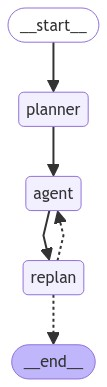

In [86]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [87]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': 'Find out who wins the 2024 Australia Open, Find out their hometown'}
{'past_steps': ('F', "The meaning of the year 2024 is associated with power, passion, and authenticity, as it is assigned the universal year number of eight in numerology. According to numerologists, each year is linked with a universal year number corresponding to a single-digit number between 1 and 9. In the case of 2024, the number 8 signifies justice, leadership, prosperity, balance, and karma. It suggests that the efforts, work, and honesty put in will yield success and abundance in the new year.\n\nMoreover, the number 2024 corresponds to the shorter numerical sequence of '24, which has a meaning of six (2+4=6) in numerology. The number six is connected with love, creativity, and compassion. Additionally, the number eight is associated with Saturn, the planet of discipline and order in astrology, indicating that people will need to be accountable for their choices in 2024.\n\nIn angelic symbolism, the 

TypeError: can only concatenate list (not "tuple") to list